# Resume Classification - Model Training and Evaluation

**Prerequisites:** analysis.ipynb must be completed first

## Data Preparation

### Import Libraries

In [1]:
import os
import re
import string
import textract
import pandas as pd
from IPython.display import display, Markdown
import seaborn as sns
from matplotlib import pylab
from matplotlib import pyplot as plt
from docx import Document

# NLP Libraries
import nltk
import spacy
import pdfplumber
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer


### Environment Configuration

In [2]:
#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Load Text-Preprocessed Resume Data

In [16]:
# Load the feature engineered dataset
data = pd.read_csv("../data/Cleaned_Resumes.csv")
print(f"Data loaded: {data.shape}")
print(f"Columns: {data.shape[1]}")
print(f"Rows: {data.shape[0]}")
data.head()

Data loaded: (77, 4)
Columns: 4
Rows: 77


,Category,Resume_Details,experience_years,skills
0,Peoplesoft,anubhav kumar singh globally competitive assig...,11 years,"['ansible', 'aws', 'change assistant', 'docker..."
1,Peoplesoft,peoplesoft database administration human capit...,7+ years,"['application designer', 'aws', 'change assist..."
2,Peoplesoft,peoplesoft database administrator gangareddy b...,4+ years,"['ae', 'app engine', 'db2', 'oel', 'oracle', '..."
3,Peoplesoft,murali peoplesoft administration infrastructur...,6 years,"['aix', 'application designer', 'c', 'change a..."
4,Peoplesoft,priyanka ramadoss mountpleasant coonoor nilgir...,4.11 years,"['apache', 'application designer', 'aws', 'c',..."


In [17]:
display(Markdown(data['Resume_Details'][3]))

murali peoplesoft administration infrastructure activities peoplesoft environments peoplesoft database scheduler platforms domains scheduler patches manually maintenance packs change assistant tool dpks installations tax updates fixes pum designer capi stat single sign sso implementation compare pre post migrations workstation developers testers configuration broker modules messages production audit dddaudit sysaudit integrity checks setup ren nodes settings clear cache scheduler peopletools upgrade elastic search sembcorp description production hrms maintenance enhancement installation setup soft hcm elm oracle database roles privileges soft instances issues scheduler weekly database maintains upgrade post refresh activities wipro ind platforms soft hcm description production hrms maintenance enhancement installation setup soft hcm oracle database roles privileges soft instances issues scheduler weekly database maintains mover scripts capi patches peoplesoft production issues tax updates pum post refresh activities soft hcm production enhancement asg usa platforms soft hcm aix description production hrms maintenance enhancement installation setup soft hcm database roles privileges soft instances issues scheduler weekly database maintains mover scripts stat capi patches peoplesoft production issues tax updates pum post refresh activities hyderabad infotech peoplesoft administrator regency peoplesoft administrator dxc formerly known csc peoplesoft administrator systems windows platforms linux erp peoplesoft hrms peopletools putty sql toad beyond compare rdbms oracle tool autosys version control tool capi stat languages c++ sql

In [18]:
data.columns

Index(['Category', 'Resume_Details', 'experience_years', 'skills'], dtype='object')

In [19]:
# Analyze category distribution
data['Category'].value_counts()

Category
React Developer    22
workday            21
Peoplesoft         20
SQL Developer      14
Name: count, dtype: int64

In [20]:
# Check data types and missing values
print("\nData Info:")
print("="*60)
print(f"Missing values: {data.isna().sum().sum()}")


Data Info:
Missing values: 0


In [21]:
# find duplicate rows
duplicates = data[data.duplicated(subset="Resume_Details", keep=False)]
duplicates


,Category,Resume_Details,experience_years,skills


In [22]:
# Import Model Building Libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Target Variable Encoding

In [23]:
le = LabelEncoder()
data['Category_encoded'] = le.fit_transform(data['Category'])


In [24]:
dict(zip(le.classes_, le.transform(le.classes_)))


{'Peoplesoft': np.int64(0),
 'React Developer': np.int64(1),
 'SQL Developer': np.int64(2),
 'workday': np.int64(3)}

In [25]:
data['Category_encoded'].value_counts()

Category_encoded
1    22
3    21
0    20
2    14
Name: count, dtype: int64

### Train-Test Split

In [26]:
# Separate Clean Text (X) and target (y)
X = data['Resume_Details'].values
y = data['Category_encoded'].values


In [14]:

# Split Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
X_train.shape, X_test.shape

((61,), (16,))

### Feature Extraction: TF-IDF

In [73]:
tfidf_all = TfidfVectorizer(
    max_features=1500,      
    ngram_range=(1,2),      # 1grams, bi-grams
    sublinear_tf=True,
    stop_words='english',
    min_df=2,               
    max_df=0.8
)

## Model Building

### Adaboost Classifier

In [74]:
from sklearn.ensemble import AdaBoostClassifier

ada_base = Pipeline([
    ('tfidf', tfidf_all),
    ('model', AdaBoostClassifier(random_state=42))
])

ada_base.fit(X_train, y_train)

ada_train_pred = ada_base.predict(X_train)
ada_test_pred  = ada_base.predict(X_test)

print("\nAdaBoost – Base Model")
print("="*70)
print(f"Training Accuracy : {accuracy_score(y_train, ada_train_pred):.4f}")
print(f"Testing Accuracy  : {accuracy_score(y_test, ada_test_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, ada_test_pred, target_names=le.classes_))

ada_cm = pd.DataFrame(confusion_matrix(y_test, ada_test_pred), index=le.classes_, columns=le.classes_)
ada_cm




AdaBoost – Base Model
Training Accuracy : 0.4426
Testing Accuracy  : 0.4375

Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React Developer       0.00      0.00      0.00         5
  SQL Developer       0.25      1.00      0.40         3
        workday       0.00      0.00      0.00         4

       accuracy                           0.44        16
      macro avg       0.31      0.50      0.35        16
   weighted avg       0.30      0.44      0.33        16



,Peoplesoft,React Developer,SQL Developer,workday
Peoplesoft,4,0,0,0
React Developer,0,0,5,0
SQL Developer,0,0,3,0
workday,0,0,4,0


### Hyper Tuning of Adaboost Classifier

In [75]:
ada_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 1.0]
}

grid_search_ada = GridSearchCV(
    Pipeline([
        ('tfidf', tfidf_all),
        ('model', AdaBoostClassifier(random_state=42))
    ]),
    param_grid=ada_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for AdaBoost...")
grid_search_ada.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search_ada.best_params_}")

best_ada = grid_search_ada.best_estimator_
print(f"\nBest estimator:\n{best_ada}")

ada_train_pred = best_ada.predict(X_train)
ada_test_pred  = best_ada.predict(X_test)

print("\nAdaBoost – Tuned Evaluation")
print("="*70)
print(f"Training Accuracy : {accuracy_score(y_train, ada_train_pred):.4f}")
print(f"Testing Accuracy  : {accuracy_score(y_test, ada_test_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, ada_test_pred, target_names=le.classes_))

ada_cm = pd.DataFrame(confusion_matrix(y_test, ada_test_pred), index=le.classes_, columns=le.classes_)
ada_cm


Starting GridSearchCV for AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters found: {'model__learning_rate': 0.01, 'model__n_estimators': 100}

Best estimator:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=1500, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('model',
                 AdaBoostClassifier(learning_rate=0.01, n_estimators=100,
                                    random_state=42))])

AdaBoost – Tuned Evaluation
Training Accuracy : 0.8197
Testing Accuracy  : 0.7500

Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       0.57      1.00      0.73         4
React Developer       0.83      1.00      0.91         5
  SQL Developer       0.00      0.00      0.00         3
        workday       1.00      0.75      0.86         4

       accuracy        

,Peoplesoft,React Developer,SQL Developer,workday
Peoplesoft,4,0,0,0
React Developer,0,5,0,0
SQL Developer,3,0,0,0
workday,0,1,0,3


### Gradient Boosting

### Hyper Tuning of Gradient Boosting Classifier

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

gb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(
    Pipeline([
        ('tfidf', tfidf_all),
        ('model', GradientBoostingClassifier(random_state=42))
    ]),
    param_grid=gb_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for Gradient Boosting...")
grid_search_gb.fit(X_train, y_train)

# Extract cross-validation results
cv_results_gb = pd.DataFrame(grid_search_gb.cv_results_)

# Columns that store fold-wise test scores
fold_cols = [col for col in cv_results_gb.columns if "split" in col and "test_score" in col]

print("\nCross-Validation Accuracy for Each Fold (Best Model):")
print("="*70)

# Find index of best parameter set
best_index = grid_search_gb.best_index_

for i, col in enumerate(fold_cols):
    print(f"Fold {i+1} Accuracy : {cv_results_gb.loc[best_index, col]:.4f}")

mean_cv_accuracy_gb = cv_results_gb.loc[best_index, 'mean_test_score']
std_cv_accuracy_gb  = cv_results_gb.loc[best_index, 'std_test_score']

print("\nCross-Validation Summary:")
print("="*70)
print(f"Mean CV Accuracy : {mean_cv_accuracy_gb:.4f}")
print(f"Std CV Accuracy  : {std_cv_accuracy_gb:.4f}")


print(f"\nBest parameters found: {grid_search_gb.best_params_}")

best_gb = grid_search_gb.best_estimator_
print(f"\nBest estimator:\n{best_gb}")



Starting GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Cross-Validation Accuracy for Each Fold (Best Model):
Fold 1 Accuracy : 1.0000
Fold 2 Accuracy : 0.8333
Fold 3 Accuracy : 0.9167
Fold 4 Accuracy : 0.9167
Fold 5 Accuracy : 1.0000

Cross-Validation Summary:
Mean CV Accuracy : 0.9333
Std CV Accuracy  : 0.0624

Best parameters found: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}

Best estimator:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=1500, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            random_state=42))])


In [77]:
gb_train_pred = best_gb.predict(X_train)
gb_test_pred  = best_gb.predict(X_test)

print("\nGradient Boosting – Tuned Evaluation")
print("="*70)
print(f"Training Accuracy : {accuracy_score(y_train, gb_train_pred):.4f}")
print(f"Testing Accuracy  : {accuracy_score(y_test, gb_test_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, gb_test_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
gb_cm = pd.DataFrame(confusion_matrix(y_test, gb_test_pred), index=le.classes_, columns= le.classes_)
gb_cm



Gradient Boosting – Tuned Evaluation
Training Accuracy : 1.0000
Testing Accuracy  : 1.0000

Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React Developer       1.00      1.00      1.00         5
  SQL Developer       1.00      1.00      1.00         3
        workday       1.00      1.00      1.00         4

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16


Confusion Matrix:


,Peoplesoft,React Developer,SQL Developer,workday
Peoplesoft,4,0,0,0
React Developer,0,5,0,0
SQL Developer,0,0,3,0
workday,0,0,0,4


## Decision Tree

In [78]:
from sklearn.tree import DecisionTreeClassifier

dt_base = Pipeline([
    ('tfidf', tfidf_all),
    ('model', DecisionTreeClassifier(random_state=42))
])

dt_base.fit(X_train, y_train)

dt_train_pred = dt_base.predict(X_train)
dt_test_pred  = dt_base.predict(X_test)

print("\nDecision Tree – Base Model")
print("="*70)
print(f"Training Accuracy : {accuracy_score(y_train, dt_train_pred):.4f}")
print(f"Testing Accuracy  : {accuracy_score(y_test, dt_test_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, dt_test_pred, target_names=le.classes_))



Decision Tree – Base Model
Training Accuracy : 1.0000
Testing Accuracy  : 0.8750

Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React Developer       0.80      0.80      0.80         5
  SQL Developer       0.75      1.00      0.86         3
        workday       1.00      0.75      0.86         4

       accuracy                           0.88        16
      macro avg       0.89      0.89      0.88        16
   weighted avg       0.89      0.88      0.88        16



### Hyper Tuning of Decision Tree

Starting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}

Best estimator:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=1500, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('model',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=2,
                                        min_samples_split=5,
                                        random_state=42))])

Decision Tree – Tuned Evaluation
Training Accuracy : 1.0000
Testing Accuracy  : 0.8750

Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React Developer       0.80      0.80      0.80         5
  SQL De

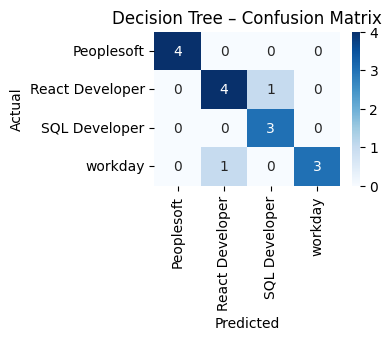

In [79]:
dt_param_grid = {
    'model__max_depth': [5, 10, 15],
    'model__min_samples_leaf': [2, 5, 10],
    'model__min_samples_split': [5, 10, 20],
    'model__criterion': ['gini', 'entropy']
}


grid_search_dt = GridSearchCV(
    Pipeline([
        ('tfidf', tfidf_all),
        ('model', DecisionTreeClassifier(random_state=42))
    ]),
    param_grid=dt_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for Decision Tree...")
grid_search_dt.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search_dt.best_params_}")

best_dt = grid_search_dt.best_estimator_
print(f"\nBest estimator:\n{best_dt}")

dt_train_pred = best_dt.predict(X_train)
dt_test_pred  = best_dt.predict(X_test)

print("\nDecision Tree – Tuned Evaluation")
print("="*70)
print(f"Training Accuracy : {accuracy_score(y_train, dt_train_pred):.4f}")
print(f"Testing Accuracy  : {accuracy_score(y_test, dt_test_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, dt_test_pred, target_names=le.classes_))

dt_cm = confusion_matrix(y_test, dt_test_pred)

plt.figure(figsize=(3,2))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Decision Tree – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Random Forest 

In [80]:
rf_pipeline = Pipeline([
('tfidf', tfidf_all),
('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])

rf_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_train_pred_rf = rf_pipeline.predict(X_train)
y_test_pred_rf = rf_pipeline.predict(X_test)

train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print("Random Forest:")
print("=" * 40)
print(f"Training Accuracy : {train_accuracy_rf:.4f}")
print(f"Testing Accuracy  : {test_accuracy_rf:.4f}")

print("\nClassification Report (Test Data):")
print(classification_report(
    y_test,
    y_test_pred_rf,
    target_names=le.classes_
))

cm_rf = pd.DataFrame(confusion_matrix(y_test, y_test_pred_rf), index=le.classes_, columns=le.classes_)
print("\nConfusion Matrix:")
print(cm_rf)

scores_rf = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy')
print("\nCross-validation Scores:",scores_rf)
print("\nMean CV Accuracy:", scores_rf.mean())

Random Forest:
Training Accuracy : 1.0000
Testing Accuracy  : 1.0000

Classification Report (Test Data):
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React Developer       1.00      1.00      1.00         5
  SQL Developer       1.00      1.00      1.00         3
        workday       1.00      1.00      1.00         4

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16


Confusion Matrix:
                 Peoplesoft  React Developer  SQL Developer  workday
Peoplesoft                4                0              0        0
React Developer           0                5              0        0
SQL Developer             0                0              3        0
workday                   0                0              0        4

Cross-validation Scores: [1.         1.         1.         0.93333333 0

## Logistic Regression

In [81]:

lr_pipeline = Pipeline([
    ('tfidf', tfidf_all),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_train_pred_lr = lr_pipeline.predict(X_train)
y_test_pred_lr = lr_pipeline.predict(X_test)

train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)

print("Logistic Regression Classifier:")
print("=" * 40)
print(f"Training Accuracy : {train_accuracy_lr:.4f}")
print(f"Testing Accuracy  : {test_accuracy_lr:.4f}")

print("\nClassification Report (Test Data):")
print(classification_report(
    y_test,
    y_test_pred_lr,
    target_names=le.classes_
))

cm_lr = pd.DataFrame(confusion_matrix(y_test, y_test_pred_lr), index=le.classes_, columns=le.classes_)
print("\nConfusion Matrix:")
print(cm_lr)

scores_lr = cross_val_score(lr_pipeline, X, y, cv=5, scoring='accuracy')
print("\nCross-validation Scores:", scores_lr)
print("\nMean CV Accuracy:", scores_lr.mean())

Logistic Regression Classifier:
Training Accuracy : 1.0000
Testing Accuracy  : 1.0000

Classification Report (Test Data):
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React Developer       1.00      1.00      1.00         5
  SQL Developer       1.00      1.00      1.00         3
        workday       1.00      1.00      1.00         4

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16


Confusion Matrix:
                 Peoplesoft  React Developer  SQL Developer  workday
Peoplesoft                4                0              0        0
React Developer           0                5              0        0
SQL Developer             0                0              3        0
workday                   0                0              0        4

Cross-validation Scores: [0.9375 1.     1.     1.     

## Naives - Bayes

### Hyper Tuning of Naive Bayes

In [82]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

nb_param_grid = {
    'model__alpha': [0.01, 0.05, 0.1, 0.5, 1.0],
    'model__fit_prior': [True, False]
}

grid_search_nb = GridSearchCV(
    Pipeline([
        ('tfidf', tfidf_all),
        ('model', MultinomialNB())
    ]),
    param_grid=nb_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for Naive Bayes...")
grid_search_nb.fit(X_train, y_train)

# Extract cross-validation results
cv_results_nb = pd.DataFrame(grid_search_nb.cv_results_)

# Columns that store fold-wise test scores
fold_cols = [col for col in cv_results_nb.columns if "split" in col and "test_score" in col]

print("\nCross-Validation Accuracy for Each Fold (Best Model):")
print("="*70)

# Find index of best parameter set
best_index = grid_search_nb.best_index_

for i, col in enumerate(fold_cols):
    print(f"Fold {i+1} Accuracy : {cv_results_nb.loc[best_index, col]:.4f}")

mean_cv_accuracy_nb = cv_results_nb.loc[best_index, 'mean_test_score']
std_cv_accuracy_nb  = cv_results_nb.loc[best_index, 'std_test_score']

print("\nCross-Validation Summary:")
print("="*70)
print(f"Mean CV Accuracy : {mean_cv_accuracy_nb:.4f}")
print(f"Std CV Accuracy  : {std_cv_accuracy_nb:.4f}")


print(f"\nBest parameters found: {grid_search_nb.best_params_}")

best_nb = grid_search_nb.best_estimator_
print(f"\nBest estimator:\n{best_nb}")


Starting GridSearchCV for Naive Bayes...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Cross-Validation Accuracy for Each Fold (Best Model):
Fold 1 Accuracy : 1.0000
Fold 2 Accuracy : 1.0000
Fold 3 Accuracy : 1.0000
Fold 4 Accuracy : 1.0000
Fold 5 Accuracy : 1.0000

Cross-Validation Summary:
Mean CV Accuracy : 1.0000
Std CV Accuracy  : 0.0000

Best parameters found: {'model__alpha': 0.01, 'model__fit_prior': True}

Best estimator:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=1500, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('model', MultinomialNB(alpha=0.01))])



Naive Bayes – Tuned Evaluation
Training Accuracy : 1.0000
Testing Accuracy  : 1.0000

Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React Developer       1.00      1.00      1.00         5
  SQL Developer       1.00      1.00      1.00         3
        workday       1.00      1.00      1.00         4

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16



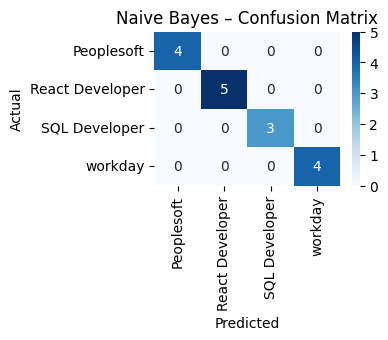

In [83]:
# Evaluation
nb_train_pred = best_nb.predict(X_train)
nb_test_pred  = best_nb.predict(X_test)

print("\nNaive Bayes – Tuned Evaluation")
print("="*70)
print(f"Training Accuracy : {accuracy_score(y_train, nb_train_pred):.4f}")
print(f"Testing Accuracy  : {accuracy_score(y_test, nb_test_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, nb_test_pred, target_names=le.classes_))

nb_cm = confusion_matrix(y_test, nb_test_pred)

plt.figure(figsize=(3,2))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Naive Bayes – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



The Naive Bayes classifier achieved 100% accuracy on both training and testing datasets.
This is primarily due to the small dataset size and the highly distinct technical vocabulary present in each resume category.
Since the job roles are skill-specific with minimal overlap, TF-IDF was able to capture discriminative features effectively, leading to perfect classification.

## Support Vector Machine

### Hyper Tuning of SVM

In [84]:
from sklearn.svm import LinearSVC

svm_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__loss': ['hinge', 'squared_hinge']
}

grid_search_svm = GridSearchCV(
    Pipeline([
        ('tfidf', tfidf_all),
        ('model', LinearSVC(random_state=42))
    ]),
    param_grid=svm_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for Linear SVM...")
grid_search_svm.fit(X_train, y_train)

# Extract cross-validation results
cv_results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Columns that store fold-wise test scores
fold_cols = [col for col in cv_results_svm.columns if "split" in col and "test_score" in col]

print("\nCross-Validation Accuracy for Each Fold (Best Model):")
print("="*70)

# Find index of best parameter set
best_index = grid_search_svm.best_index_

for i, col in enumerate(fold_cols):
    print(f"Fold {i+1} Accuracy : {cv_results_svm.loc[best_index, col]:.4f}")

mean_cv_accuracy_svm = cv_results_svm.loc[best_index, 'mean_test_score']
std_cv_accuracy_svm  = cv_results_svm.loc[best_index, 'std_test_score']

print("\nCross-Validation Summary:")
print("="*70)
print(f"Mean CV Accuracy : {mean_cv_accuracy_svm:.4f}")
print(f"Std CV Accuracy  : {std_cv_accuracy_svm:.4f}")

print(f"\nBest parameters found: {grid_search_svm.best_params_}")

best_svm = grid_search_svm.best_estimator_
print(f"\nBest estimator:\n{best_svm}")

Starting GridSearchCV for Linear SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Cross-Validation Accuracy for Each Fold (Best Model):
Fold 1 Accuracy : 1.0000
Fold 2 Accuracy : 1.0000
Fold 3 Accuracy : 1.0000
Fold 4 Accuracy : 1.0000
Fold 5 Accuracy : 1.0000

Cross-Validation Summary:
Mean CV Accuracy : 1.0000
Std CV Accuracy  : 0.0000

Best parameters found: {'model__C': 1, 'model__loss': 'hinge'}

Best estimator:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=1500, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('model', LinearSVC(C=1, loss='hinge', random_state=42))])



Linear SVM – Tuned Evaluation
Training Accuracy : 1.0000
Testing Accuracy  : 1.0000

Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React Developer       1.00      1.00      1.00         5
  SQL Developer       1.00      1.00      1.00         3
        workday       1.00      1.00      1.00         4

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16



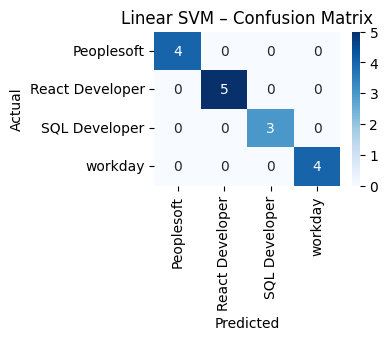

In [85]:

# Evaluation
svm_train_pred = best_svm.predict(X_train)
svm_test_pred  = best_svm.predict(X_test)

print("\nLinear SVM – Tuned Evaluation")
print("="*70)
print(f"Training Accuracy : {accuracy_score(y_train, svm_train_pred):.4f}")
print(f"Testing Accuracy  : {accuracy_score(y_test, svm_test_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, svm_test_pred, target_names=le.classes_))

svm_cm = confusion_matrix(y_test, svm_test_pred)

plt.figure(figsize=(3,2))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Linear SVM – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Data Leakage Check (Shuffle Labels Test)

In [86]:
from sklearn.utils import shuffle

y_shuffled = shuffle(y, random_state=42)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y_shuffled, test_size=0.2, random_state=42
)

y_train_pred_s = best_svm.predict(X_train_s)
y_test_pred_s = best_svm.predict(X_test_s)

print("Training Accuracy:", accuracy_score(y_train_s, y_train_pred_s))
print("Testing Accuracy after label shuffling:", accuracy_score(y_test_s, y_test_pred_s))


Training Accuracy: 0.29508196721311475
Testing Accuracy after label shuffling: 0.3125


To rule out data leakage, a label shuffling experiment was conducted.

It randomly rearranges the target labels, breaking any real relationship between features and labels. After shuffling, the model’s training and testing accuracy dropped to near-random levels (~0.30), which is expected for 4 classes and confirms that there is no data leakage or memorization. This validates that the previously observed perfect accuracy on the real dataset is due to genuine patterns in the resumes rather than overfitting or pipeline errors, giving confidence in the model’s integrity.

Because the dataset contains strongly role-specific technical vocabularies, making it linearly separable. In real HR systems, resumes overlap heavily, so accuracy would be lower

## Model Evaluation

In [89]:
model_results = pd.DataFrame({
    "Model": [
        "Naive Bayes",
        "Logistic Regression",
        "Linear SVM",
        "Random Forest",
        "Gradient Boosting",
        "AdaBoost",
        "Decision Tree"
    ],
    "Train Accuracy": [
        accuracy_score(y_train, nb_train_pred),
        accuracy_score(y_train, y_train_pred_lr),
        accuracy_score(y_train, svm_train_pred),
        train_accuracy_rf,
        accuracy_score(y_train, gb_train_pred),
        accuracy_score(y_train, ada_train_pred),
        accuracy_score(y_train, dt_train_pred)
    ],
    "Test Accuracy": [
        accuracy_score(y_test, nb_test_pred),
        accuracy_score(y_test, y_test_pred_lr),
        accuracy_score(y_test, svm_test_pred),
        test_accuracy_rf,
        accuracy_score(y_test, gb_test_pred),
        accuracy_score(y_test, ada_test_pred),
        accuracy_score(y_test, dt_test_pred)
    ],
    "CV Mean Accuracy": [
        mean_cv_accuracy_nb,             # NB
        scores_lr.mean(),                 # LR
        mean_cv_accuracy_svm,              # SVM
        scores_rf.mean(),                 # RF
        mean_cv_accuracy_gb,              # GB
        grid_search_ada.best_score_,   # AdaBoost
        grid_search_dt.best_score_     # Decision Tree
    ],
    "CV Std": [
        std_cv_accuracy_nb,
        scores_lr.std(),
        std_cv_accuracy_svm,
        scores_rf.std(),
        std_cv_accuracy_gb,
        grid_search_ada.cv_results_['std_test_score'][grid_search_ada.best_index_],
        grid_search_dt.cv_results_['std_test_score'][grid_search_dt.best_index_]
    ]
})

model_results.sort_values(
    by=["Test Accuracy", "CV Mean Accuracy", "CV Std"],
    ascending=[False, False, True]
)



,Model,Train Accuracy,Test Accuracy,CV Mean Accuracy,CV Std
0,Naive Bayes,1.000000,1.000,1.000000,0.000000
2,Linear SVM,1.000000,1.000,1.000000,0.000000
1,Logistic Regression,1.000000,1.000,0.987500,0.025000
3,Random Forest,1.000000,1.000,0.960000,0.053333
4,Gradient Boosting,1.000000,1.000,0.933333,0.062361
6,Decision Tree,1.000000,0.875,0.967949,0.039307
5,AdaBoost,0.819672,0.750,0.737179,0.098142


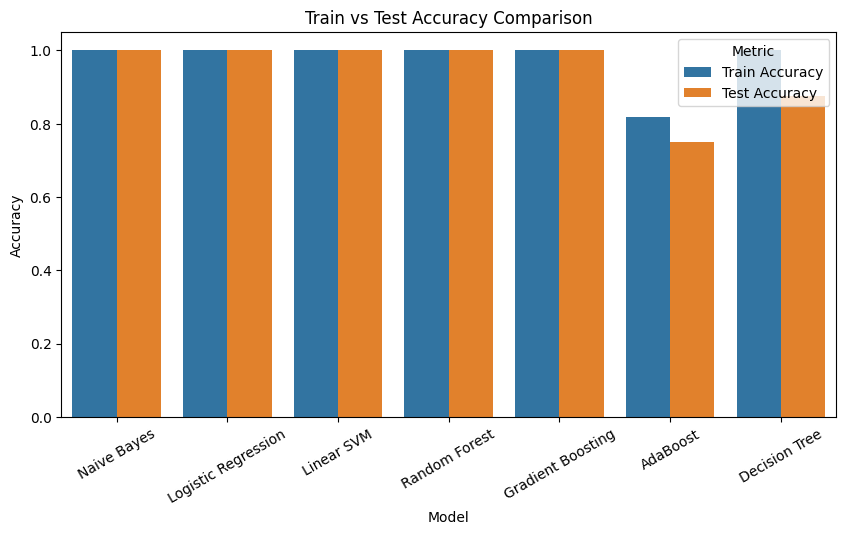

In [ ]:
# Train vs Test Accuracy

model_results_melted = model_results.melt(
    id_vars="Model",
    value_vars=["Train Accuracy", "Test Accuracy"],
    var_name="Metric",
    value_name="Accuracy"
)

plt.figure(figsize=(10,5))
sns.barplot(
    x="Model",
    y="Accuracy",
    hue="Metric",
    data=model_results_melted
)
plt.title("Train vs Test Accuracy Comparison")
plt.xticks(rotation=30)
plt.show()


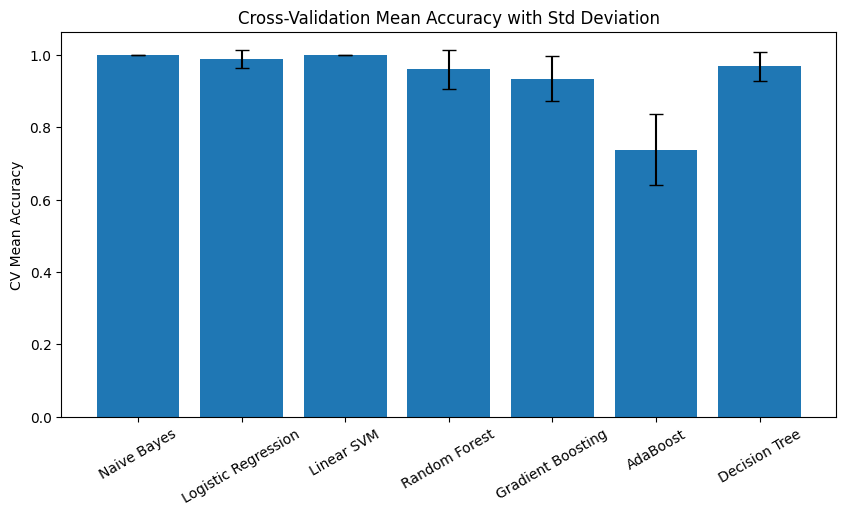

In [97]:
# Cross-Validation Mean Accuracy with Std Deviation

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(model_results))
y = model_results["CV Mean Accuracy"]
yerr = model_results["CV Std"]

plt.figure(figsize=(10,5))
plt.bar(x, y, yerr=yerr, capsize=5)
plt.xticks(x, model_results["Model"], rotation=30)
plt.ylabel("CV Mean Accuracy")
plt.title("Cross-Validation Mean Accuracy with Std Deviation")

plt.show()


## Model Dump

In [99]:
import joblib
import os

# Save the entire pipeline (TF-IDF + Naive Bayes)
joblib.dump(best_nb, "../models/resume_classifier_nb_pipeline.pkl")

joblib.dump(le, "../models/label_encoder.pkl")

print("Naive - Bayes Model pipeline saved successfully!")
print("LabelEncoder saved successfully!")

Naive - Bayes Model pipeline saved successfully!
LabelEncoder saved successfully!


In [100]:
import joblib

model = joblib.load("../models/resume_classifier_nb_pipeline.pkl")
label_encoder = joblib.load("../models/label_encoder.pkl")

print("Model loaded. Ready to predict.")

Model loaded. Ready to predict.


## Model Predictions on New Data

In [ ]:
# --- Imports ---
import os
import re
from pdf2docx import Converter
import win32com.client as win32
from docx import Document
import pandas as pd
import pickle

# Extract text from DOCX (from your code)

def extract_text_from_docx(file_path):
    doc = Document(file_path)
    full_text = []

    for para in doc.paragraphs:
        if para.text.strip():
            full_text.append(para.text)
    for table in doc.tables:
        for row in table.rows:
            row_text = " ".join(cell.text.strip() for cell in row.cells if cell.text.strip())
            if row_text:
                full_text.append(row_text)
    return ' '.join(full_text)

# Convert PDF/DOC → DOCX (from your code)

def convert_to_docx(file_path):
    ext = os.path.splitext(file_path)[1].lower()
    if ext == '.pdf':
        docx_path = os.path.splitext(file_path)[0] + '.docx'
        cv = Converter(file_path)
        cv.convert(docx_path, start=0, end=None)
        cv.close()
        return docx_path
    elif ext == '.doc':
        docx_path = file_path + 'x'
        word = win32.Dispatch("Word.Application")
        word.Visible = False
        doc = word.Documents.Open(file_path)
        doc.SaveAs(docx_path, FileFormat=16)  # DOCX
        doc.Close()
        word.Quit()
        return docx_path
    elif ext == '.docx':
        return file_path
    else:
        raise ValueError("Unsupported file type: PDF, DOC, DOCX only.")



import re
import spacy
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# ----------------------------
# Load SpaCy
# ----------------------------
nlp = spacy.load("en_core_web_sm")

# tokenizer (kept from your code)
tokenizer = RegexpTokenizer(r'[A-Za-z][A-Za-z0-9\+\#\.-]*')

# ----------------------------
# Regex patterns
# ----------------------------

TECH_PATTERN = re.compile(
    r"""
    (
        (html|css|v|ec|pt)  |                # html, css, v, ec, pt (specific terms)
        c(\+\+|\#)        |                   # c++, c#
        [a-z]+[0-9]+      |                   # exclude html5, react18, etc.
        [0-9]+[a-z]+      |                   # exclude v8, ec2, etc.
        [a-z]+[_-][a-z0-9]+ |                  # people_soft, web_server
        [a-z]{3,}         (?:[a-z0-9]+)?      # sql, oracle, peoplesoft
    )
    """,
    re.X
)


# resume / profile boilerplate
FLUFF_PATTERN = re.compile(
    r"""
    ^(
        responsibility|responsibilities|
        professional|profile|summary|objective|
        organization|company|
        education|college|university|
        information|details|
        customer|client|user|
        service|services|
        work|experience|career|
        title|personal|dates|fields|also|additionally|various|active
    )s?$
    """,
    re.X
)

# action verbs (regex-based, no list)
ACTION_VERB_PATTERN = re.compile(r'.*(ing|ed)$')

# ----------------------------
# Stopwords 
# ----------------------------

generic_resume_words = ['date', 'birth', 'nationality','indian', 'place','design','development','role','like','technology','service','environment','experience','summary', 'projects','project','team','teams','support','skill','responsible','knowledge','tables', 'reports']
    
custom_stopwords = [ 'people','process','processes', 'tools','servers','data', 'table', 'function','stored','business','custom','report','integration','core','connector', 'js','web', 'cs', 'good', 'worked', 'system', 'team', 'workded','created','working','involved', 'support', 'involved', 'skill','skills', 'experience','project', 'projects', 'handling', 'management', 'knowledge', 'responsible','server', 'application', 'applications', 'technologies', 'application server']


# Combine NLTK + generic + custom
stop_words = list(set(stopwords.words('english')).union(generic_resume_words).union(custom_stopwords))


# Main preprocessing function

def preprocess_resume(text):

    if not text:
        return ""

    text = str(text)

    # ----------------------------------------
    # Normalize separators
    # ----------------------------------------
    text = text.replace("\\", " ")
    text = re.sub(r'/', ' ', text)
    text = re.sub(r'(?<=\w)[-](?=\w)', '_', text)
    text = re.sub(r'[\)\}\]\(\[\:;,"\'`~!@\$%\^&\*\=<>\?]', ' ', text)

    # ----------------------------------------
    # Remove HTML and URLs
    # ----------------------------------------
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    # ----------------------------------------
    # Remove dates
    # ----------------------------------------
    text = re.sub(r'\b\d{1,2}(st|nd|rd|th)\b', ' ', text, flags=re.I)
    text = re.sub(r'\b(19|20)\d{2}\b', ' ', text)

    text = re.sub(
        r'\b(jan|january|feb|february|mar|march|apr|april|may|jun|june|'
        r'jul|july|aug|august|sep|sept|september|oct|october|nov|november|dec|december)\b',
        ' ',
        text,
        flags=re.I
    )

    # ----------------------------------------
    # Remove standalone decimals
    # ----------------------------------------
    text = re.sub(r'(?<![a-zA-Z])\d+\.\d+(?![a-zA-Z])', ' ', text)

    # ----------------------------------------
    # Normalize whitespace
    # ----------------------------------------
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'\b([a-zA-Z]+)[0-9].*?\b', r'\1', text)



    # ----------------------------------------
    # SpaCy processing
    # ----------------------------------------
    doc = nlp(text)

    clean_tokens = []

    for token in doc:

        t = token.text.lower().strip(".-_")

        if not t:
            continue

        # grammar glue
        if token.pos_ in {"PRON", "DET", "CCONJ", "SCONJ", "PART", "INTJ"}:
            continue

        # remove numbers / dates
        if token.ent_type_ in {"DATE", "TIME", "CARDINAL", "QUANTITY", "PERCENT"}:
            continue

        # remove locations (you already included this)
        if token.ent_type_ in {"GPE", "LOC", "FAC"}:
            continue

        if token.ent_type_ == "NORP":
            continue

        # stopwords (human language only)
        if t in stop_words:
            continue

        # pure numbers / decimals
        if re.fullmatch(r'\d+', t) or re.fullmatch(r'\d+\.\d+', t):
            continue

        # single letters except c
        if len(t) == 1 and t != 'c':
            continue

        # resume fluff
        if FLUFF_PATTERN.match(t):
            continue

        # action verbs
        if ACTION_VERB_PATTERN.match(t):
            continue

        # KEEP only technical-looking tokens
        if TECH_PATTERN.fullmatch(t):
            clean_tokens.append(t)

    return " ".join(clean_tokens)



#  Predict function using your preprocess_resume

def predict_resume(file_path):
    # Convert to DOCX if needed
    docx_file = convert_to_docx(file_path)
    
    # Extract raw text
    raw_text = extract_text_from_docx(docx_file)
    
    # Clean text using your preprocessing function
    clean_text = preprocess_resume(raw_text)
    
    encoded_label = model.predict([clean_text])  # This returns integer label
    
    # Convert encoded label back to original category
    predicted_category = label_encoder.inverse_transform(encoded_label)[0]
    
    return predicted_category, raw_text, clean_text



In [102]:
for i in range(len(label_encoder.classes_)):
    print(f"{i} : {label_encoder.inverse_transform([i])[0]}")

0 : Peoplesoft
1 : React Developer
2 : SQL Developer
3 : workday


In [104]:
# Test Prediction

resume_file = r'..\data\Test Resumes\React-Developer-Resume.pdf'

category, raw_text, clean_text = predict_resume(resume_file)

print(f"\n\nPredicted Category: {category}")
print("\n--- Raw Text ---\n", raw_text[:500], "...\n")  # first 500 chars
print("\n--- Cleaned Text ---\n", clean_text[:500], "...\n")  # first 500 chars


[INFO] Start to convert ..\data\Test Resumes\React-Developer-Resume.pdf
[INFO] [1/4] Opening document...
[INFO] [2/4] Analyzing document...
[INFO] [3/4] Parsing pages...
[INFO] (1/3) Page 1
[INFO] (2/3) Page 2
[INFO] (3/3) Page 3
[INFO] [4/4] Creating pages...
[INFO] (1/3) Page 1
[INFO] (2/3) Page 2
[INFO] (3/3) Page 3
[INFO] Terminated in 8.37s.




Predicted Category: React Developer

--- Raw Text ---
 Senior Fronted Developer, Tech Lead Profile Jest, React Testing Library, MaterialUI. Frontend Engineer 	Dec 2020 - Feb 2022 Grubhub, Chicago 
Field: Food delivery (one of the biggest aggregator for restaurants and cafes).  Responsibilities: 	Work as main frontend engineer in a post purchase experience 	team (order tracking). 	Implement new designs from Figma in a pixel perfect manner 	Create an experiments for A/B testing new features. 	Deeply work with the test coverage - spent near 40% of codi ...


--- Cleaned Text ---
 senior developer tech lead jest react library materialui frontend engineer grubhub chicago field food delivery one biggest aggregator restaurants cafes main frontend engineer post purchase order implement new designs figma pixel perfect manner create experiments new features deeply test coverage spent near time tests fix old flaky tests tech stack react typescript jest react library mockito circleci jenkins scs

## Model Building Complete!

### Summary of Model Building

1. **Data Preparation & Preprocessing** : Load, inspect, and clean resume dataset; encode categories, split train/test sets, and extract TF-IDF features.
2. **Model Building & Tuning** : Train, tune, and evaluate multiple classifiers including Naive Bayes, Logistic Regression, SVM, Random Forest, Gradient Boosting, AdaBoost, and Decision Tree.
3. **Model Evaluation & Comparison** : Compare models using training/testing accuracy, cross-validation metrics, and visualizations to select the best performing model.
4. **Model Dump & Persistence** : Save the final Naive Bayes pipeline and LabelEncoder for reuse in production.
5. **Model Predictions on New Data** : Preprocess new resumes from PDF/DOC/DOCX, predict job category using the trained model, and return raw and cleaned text.
